# Epidemic spreading using the SIS model

Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: Susceptible (S), i.e., healthy but can get infected; Infected (I), i.e., has the disease and can spread it to its neighbors.

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state, as a function of the infection probability of the disease λ (you can use values from λ=0 to λ=0.3 with Δλ=0.01), for two different values of the recovery probability μ (e.g. 0.2, 0.4). For each value of  μ, the students should use four different networks composed of 1000 nodes: Erdös-Rényi (ER) with k = 4, ER with k =6, Barábasi-Albert (BA) with k =4 and BA with k =6. Ideally, the epidemic diagrams for the four networks should be represented in the same plot to allow comparisons between networks.

Optionally (but mandatory if you want to opt to the maximum grade), compare the ρ(β) result from Monte Carlo simulations with the theoretical prediction provided by the Microscopic Markov Chain Approach (MMCA) model.

Monte Carlo simulations may require a lot of computing time, thus it is recommended the use of compiled languages (e.g., Julia, C/C++, C#, Java). In general, and mainly if you are using interpreted languages (e.g., python, Matlab, octave, R), first make tests with small networks, a few time steps, and a few repetitions, before making the definitive simulations. You can adapt the code used in the lab to carry out this task or compute your code from scratch (details on how to implement the simulations for the SIS model are given in the attached document). If you decide to get inspiration from the code explained in the lab, please bear in mind that this code simulates SIR dynamics in well-mixed populations. This means that the code should be modified to change the SIR dynamics to a SIS dynamics and to incorporate the existence of a network driving the contagions. 

The delivery must include:

- Source code

- Networks used

- Results files

- Document (in PDF) including:
    
    - Short explanations on how have you done the required work (software, decisions, etc.)

    - The plots indicated above, pointing out “all” the parameters of the corresponding simulation.
    
    - An explanation of the differences found between spreading dynamics in ER and BA networks.



In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from sis_model import SISModel
import numpy as np


In [30]:
N = 200
mu_values = [0.2, 0.4]
lambda_range = np.arange(0, 0.41, 0.01)
Tmax = 500
Ttrans = 200
Nrep = 10

In [3]:
def create_network(network_type, avg_degree):
    if network_type == "ER":
        p = avg_degree / (N - 1)
        return nx.erdos_renyi_graph(N, p)
    elif network_type == "BA":
        m = max(1, avg_degree // 2)
        return nx.barabasi_albert_graph(N, m)

In [27]:
def simulate(network, beta, mu, Tmax, Ttrans, Nrep):
    rho_vals = []
    rho_time = []
    for i in range(Nrep):
        model = SISModel(network, beta, mu)
        rho, r_t = model.run(Tmax=Tmax, Ttrans=Ttrans)
        rho_time.append(r_t)
        rho_vals.append(rho)  
     # Compute mean prevalence per time step across repetitions
    rho_time_mean = np.array(rho_time).mean(axis=0)  # Shape: (Tmax,)
    return np.mean(rho_vals), rho_time_mean

In [5]:
def iterateSIS_MMCA_stationary_network(G, beta, mu, rho0=0.2, tol=1e-6, max_iter=10000):
    N = G.number_of_nodes()
    A = nx.to_numpy_array(G)  
    rho_I = np.full(N, rho0)

    for _ in range(max_iter):
        rho_old = rho_I.copy()

        q = np.ones(N)
        for i in range(N):
            prod = 1.0
            for j in range(N):
                if A[i, j] == 1:
                    prod *= (1 - beta * rho_old[j])
            q[i] = 1 - prod

        rho_I = (1 - mu) * rho_old + (1 - rho_old) * q

        if np.linalg.norm(rho_I - rho_old) < tol:
            break

    return np.mean(rho_I)

In [6]:
def compute_MMCA_curve_network(beta_range, G, mu, rho0=0.2):
    mmca_rho = []
    for beta in beta_range:
        rho = iterateSIS_MMCA_stationary_network(G, beta, mu, rho0)
        mmca_rho.append(rho)
    return mmca_rho

In [15]:
def plot_rho_time(rhos_time, mu, k, net_type):
    # Define the representative beta values you want to plot
    selected_betas = [0.02, 0.07, 0.12, 0.17, 0.22, 0.27]

    plt.figure(figsize=(10, 6))

    for (network_key, beta), rho_time in rhos_time.items():
        if any(abs(beta - selected) < 1e-3 for selected in selected_betas):  # allow small numerical errors
            t_values = range(Tmax)
            plt.plot(t_values, rho_time, label=f"λ={beta:.2f}")

    plt.xlabel("t")
    plt.ylabel("ρ(t)")
    plt.title(f"SIS dynamics ρ(t) curves for μ={mu}, <k> = {k}, {net_type}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
import os

def save_network(G, net_type, k, mu):
    # Create a folder if it doesn't exist
    folder = f"networks/{net_type}"
    os.makedirs(folder, exist_ok=True)
    
    # Format μ nicely (e.g., avoid 0.1 becoming 0.1000000000001)
    mu_str = f"{mu:.2f}"
    
    # Create a filename based on net_type, k, and mu
    filename = f"{folder}/{net_type}_k_{k}_mu_{mu_str}.net"
    
    # Save the graph in Pajek .net format
    nx.write_pajek(G, filename)
    print(f"Saved network to {filename}")


Las redes BA tienen una estructure heterogénea, en la que hay muchos nodos con pocos enlaces y pocos hubs con muchos enlaces. Asumir que todos los nodos tienen grado _k_ no representa bien el modelo, por lo que en el siguiente código solo se muestra la simulación MMCA teórica para el modelo ER.


==== μ = 0.2 ====
Saved network to networks/ER/ER_k_4_mu_0.20.net
Simulating for network: ER <k> =4
  λ = 0.00 (1/41)
  λ = 0.01 (2/41)
  λ = 0.02 (3/41)
  λ = 0.03 (4/41)
  λ = 0.04 (5/41)
  λ = 0.05 (6/41)
  λ = 0.06 (7/41)
  λ = 0.07 (8/41)
  λ = 0.08 (9/41)
  λ = 0.09 (10/41)
  λ = 0.10 (11/41)
  λ = 0.11 (12/41)
  λ = 0.12 (13/41)
  λ = 0.13 (14/41)
  λ = 0.14 (15/41)
  λ = 0.15 (16/41)
  λ = 0.16 (17/41)
  λ = 0.17 (18/41)
  λ = 0.18 (19/41)
  λ = 0.19 (20/41)
  λ = 0.20 (21/41)
  λ = 0.21 (22/41)
  λ = 0.22 (23/41)
  λ = 0.23 (24/41)
  λ = 0.24 (25/41)
  λ = 0.25 (26/41)
  λ = 0.26 (27/41)
  λ = 0.27 (28/41)
  λ = 0.28 (29/41)
  λ = 0.29 (30/41)
  λ = 0.30 (31/41)
  λ = 0.31 (32/41)
  λ = 0.32 (33/41)
  λ = 0.33 (34/41)
  λ = 0.34 (35/41)
  λ = 0.35 (36/41)
  λ = 0.36 (37/41)
  λ = 0.37 (38/41)
  λ = 0.38 (39/41)
  λ = 0.39 (40/41)
  λ = 0.40 (41/41)


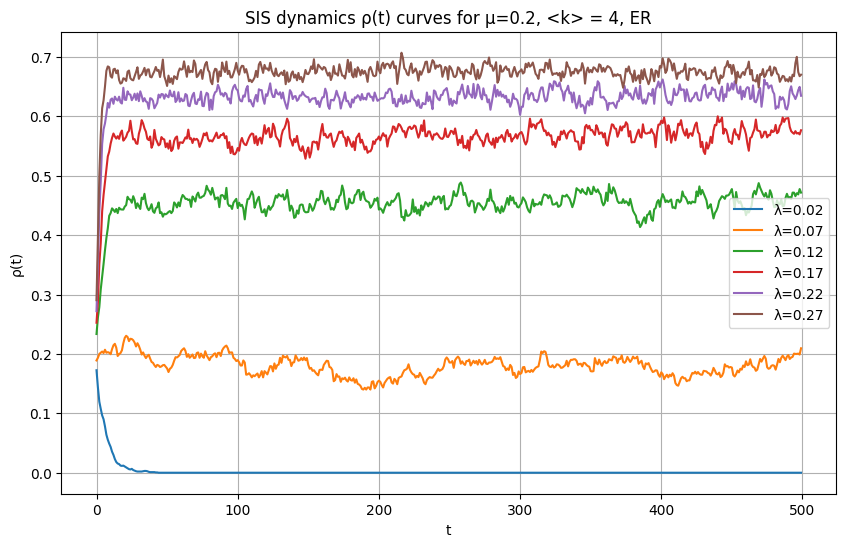

Saved network to networks/ER/ER_k_6_mu_0.20.net
Simulating for network: ER <k> =6
  λ = 0.00 (1/41)
  λ = 0.01 (2/41)
  λ = 0.02 (3/41)
  λ = 0.03 (4/41)
  λ = 0.04 (5/41)
  λ = 0.05 (6/41)
  λ = 0.06 (7/41)
  λ = 0.07 (8/41)
  λ = 0.08 (9/41)
  λ = 0.09 (10/41)
  λ = 0.10 (11/41)
  λ = 0.11 (12/41)
  λ = 0.12 (13/41)
  λ = 0.13 (14/41)
  λ = 0.14 (15/41)
  λ = 0.15 (16/41)
  λ = 0.16 (17/41)
  λ = 0.17 (18/41)
  λ = 0.18 (19/41)
  λ = 0.19 (20/41)


KeyboardInterrupt: 

In [35]:
for mu in mu_values:
    print(f"\n==== μ = {mu} ====")
    results = {}

    for net_type in ["ER", "BA"]:
        for k in [4, 6]:
            key = f"{net_type} <k> ={k}"
            G = create_network(net_type, k)
            save_network(G, net_type, k, mu)
            rhos = []
            rhos_time = {}

            print(f"Simulating for network: {key}")
            for i, beta in enumerate(lambda_range):
                print(f"  λ = {beta:.2f} ({i+1}/{len(lambda_range)})")
                avg_rho, rho_time = simulate(G, beta, mu, Tmax, Ttrans, Nrep)
                rhos.append(avg_rho)
                rhos_time[(key, beta)] = rho_time  # store by (network key, beta)
            
            plot_rho_time(rhos_time, mu, k, net_type)

            results[key] = rhos
            mmca_curve = compute_MMCA_curve_network(lambda_range, G, mu)

            results[key + " MMCA"] = mmca_curve

    plt.figure(figsize=(10, 6))
    
    for key, rhos in results.items():
        if "MMCA" in key:
            plt.plot(lambda_range, rhos, "--", label=key)
        else:
            plt.plot(lambda_range, rhos, label=key)

    plt.xlabel("λ (Infection probability)")
    plt.ylabel("⟨ρ⟩ (Fraction of infected nodes)")
    plt.title(f"SIS Epidemic Dynamics μ = {mu}")
    plt.legend()
    plt.grid(True)
    plt.show()



==== μ = 0.2 ====
Simulating for network: ER <k>=4
  λ = 0.00 (1/31)
  λ = 0.01 (2/31)
  λ = 0.02 (3/31)
  λ = 0.03 (4/31)
  λ = 0.04 (5/31)
  λ = 0.05 (6/31)
  λ = 0.06 (7/31)
  λ = 0.07 (8/31)
  λ = 0.08 (9/31)
  λ = 0.09 (10/31)
  λ = 0.10 (11/31)
  λ = 0.11 (12/31)
  λ = 0.12 (13/31)
  λ = 0.13 (14/31)
  λ = 0.14 (15/31)
  λ = 0.15 (16/31)
  λ = 0.16 (17/31)
  λ = 0.17 (18/31)
  λ = 0.18 (19/31)
  λ = 0.19 (20/31)
  λ = 0.20 (21/31)
  λ = 0.21 (22/31)
  λ = 0.22 (23/31)
  λ = 0.23 (24/31)
  λ = 0.24 (25/31)
  λ = 0.25 (26/31)
  λ = 0.26 (27/31)
  λ = 0.27 (28/31)
  λ = 0.28 (29/31)
  λ = 0.29 (30/31)
  λ = 0.30 (31/31)
Simulating for network: ER <k>=6
  λ = 0.00 (1/31)
  λ = 0.01 (2/31)
  λ = 0.02 (3/31)
  λ = 0.03 (4/31)
  λ = 0.04 (5/31)
  λ = 0.05 (6/31)
  λ = 0.06 (7/31)
  λ = 0.07 (8/31)
  λ = 0.08 (9/31)
  λ = 0.09 (10/31)
  λ = 0.10 (11/31)
  λ = 0.11 (12/31)
  λ = 0.12 (13/31)
  λ = 0.13 (14/31)
  λ = 0.14 (15/31)
  λ = 0.15 (16/31)
  λ = 0.16 (17/31)
  λ = 0.17 (18/31)
  

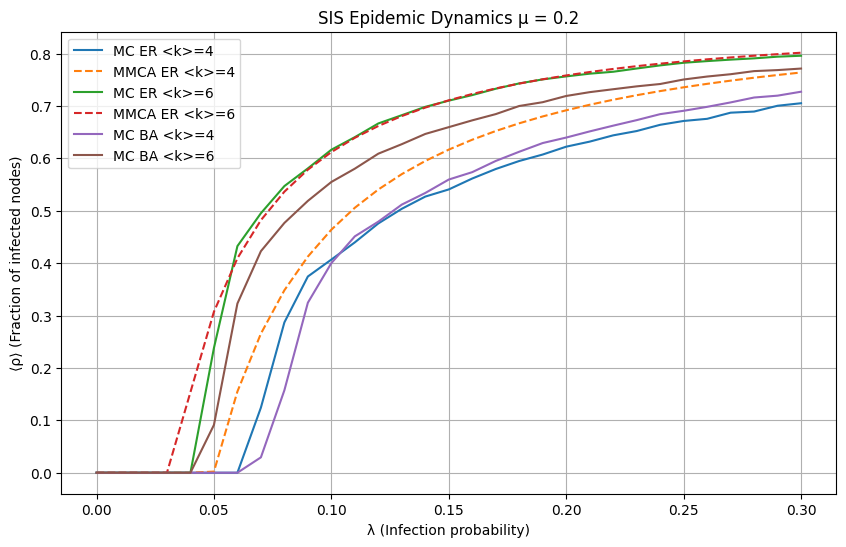


==== μ = 0.4 ====
Simulating for network: ER <k>=4
  λ = 0.00 (1/31)
  λ = 0.01 (2/31)
  λ = 0.02 (3/31)
  λ = 0.03 (4/31)
  λ = 0.04 (5/31)
  λ = 0.05 (6/31)
  λ = 0.06 (7/31)
  λ = 0.07 (8/31)
  λ = 0.08 (9/31)
  λ = 0.09 (10/31)
  λ = 0.10 (11/31)
  λ = 0.11 (12/31)
  λ = 0.12 (13/31)
  λ = 0.13 (14/31)
  λ = 0.14 (15/31)
  λ = 0.15 (16/31)
  λ = 0.16 (17/31)
  λ = 0.17 (18/31)
  λ = 0.18 (19/31)
  λ = 0.19 (20/31)
  λ = 0.20 (21/31)
  λ = 0.21 (22/31)
  λ = 0.22 (23/31)
  λ = 0.23 (24/31)
  λ = 0.24 (25/31)
  λ = 0.25 (26/31)
  λ = 0.26 (27/31)
  λ = 0.27 (28/31)
  λ = 0.28 (29/31)
  λ = 0.29 (30/31)
  λ = 0.30 (31/31)
Simulating for network: ER <k>=6
  λ = 0.00 (1/31)
  λ = 0.01 (2/31)
  λ = 0.02 (3/31)
  λ = 0.03 (4/31)
  λ = 0.04 (5/31)
  λ = 0.05 (6/31)
  λ = 0.06 (7/31)
  λ = 0.07 (8/31)
  λ = 0.08 (9/31)
  λ = 0.09 (10/31)
  λ = 0.10 (11/31)
  λ = 0.11 (12/31)
  λ = 0.12 (13/31)
  λ = 0.13 (14/31)
  λ = 0.14 (15/31)
  λ = 0.15 (16/31)
  λ = 0.16 (17/31)
  λ = 0.17 (18/31)
  

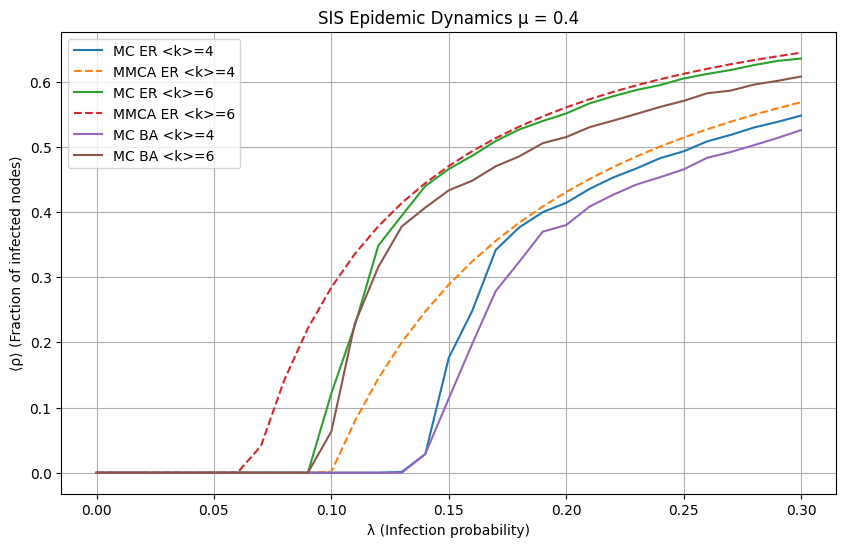

In [8]:
for mu in mu_values:
    print(f"\n==== μ = {mu} ====")
    results = {}

    for net_type in ["ER", "BA"]:
        for k in [4, 6]:
            key = f"{net_type} <k>={k}"
            G = create_network(net_type, k)
            rhos = []

            print(f"Simulating for network: {key}")
            for i, beta in enumerate(lambda_range):
                print(f"  λ = {beta:.2f} ({i+1}/{len(lambda_range)})")
                avg_rho = simulate(G, beta, mu, Tmax, Ttrans, Nrep)
                rhos.append(avg_rho)

            results[key] = rhos

    plt.figure(figsize=(10, 6))

    for key, rhos in results.items():
        plt.plot(lambda_range, rhos, label=f"MC {key}")

        if "ER" in key:
            avg_k = int(key.split("=")[-1])
            mmca_curve = compute_MMCA_curve(lambda_range, avg_k, mu)
            plt.plot(lambda_range, mmca_curve, "--", label=f"MMCA {key}")

    plt.xlabel("λ (Infection probability)")
    plt.ylabel("⟨ρ⟩ (Fraction of infected nodes)")
    plt.title(f"SIS Epidemic Dynamics μ = {mu}")
    plt.legend()
    plt.grid(True)
    plt.show()
